In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import sys
sys.path.append('../')
from utils import visualize_data_sample
from sklearn.utils import shuffle
from keras.api.models import Model, Sequential
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout, ReLU, RandomBrightness, RandomContrast, RandomFlip, RandomZoom, GaussianNoise
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.api.metrics import Accuracy
import tensorflow as tf
import keras
import albumentations as A

In [2]:
x_data = np.load('../datasets/tp4/pipeline_images.npy')
y_data = np.load('../datasets/tp4/pipeline_predections.npy')

In [3]:
print(f'x_data shape : {x_data.shape}')
print(f'y_data shape : {y_data.shape}')

x_data shape : (1112, 228, 308, 3)
y_data shape : (1112, 4)


In [4]:
def print_angle_value(tan):
    print(f'rad value : {math.atan(tan)}')
    print(f'deg value : {math.degrees(math.atan(tan))}')

In [5]:
def preprocess_input(x_data):
    gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_data])
    gray_images = gray_images.astype('float32') / 255.0
    gray_images = np.expand_dims(gray_images, -1)
    
    return gray_images

In [6]:
def preprocess_output(y_data):
    y_data = y_data[:, 0:2]
    y_data[:, 0] = np.abs(y_data[:, 0])
    y_data[:, 0] = np.clip(y_data[:, 0], 0, 5)
    y_data[:, 1] = (y_data[:, 1] >= 0).astype(int)
    return y_data

In [7]:
#x_data = preprocess_input(x_data)
y_data = preprocess_output(y_data)

In [13]:
transform_pipeline = A.Compose([
    A.RandomBrightnessContrast(p=0.2),    
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),  
    A.CLAHE(p=0.1),                      
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.2),  
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2), 
    A.ChannelShuffle(p=0.1),               
    A.MotionBlur(blur_limit=3, p=0.1), 
    A.ISONoise(p=0.2)
])

In [25]:
test = transform_pipeline(image=x_data)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'cv::Mat::locateROI'


In [14]:
test = []
for image in x_data:
    transformed_images = transform_pipeline(image=image)['image']
    test.append(transformed_images)
    

(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 308, 3)
(228, 

In [16]:
test = np.array(test)

(<Axes: >, <matplotlib.image.AxesImage at 0x193ff9443d0>)

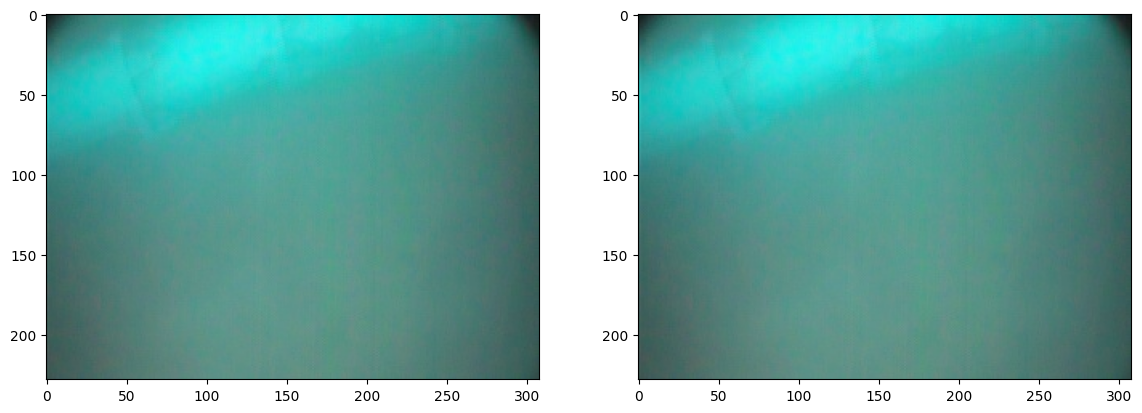

In [24]:
idx = 10
plt.figure(figsize=(14,8))
plt.subplot(1,2,1), plt.imshow(x_data[idx])
plt.subplot(1,2,2), plt.imshow(test[idx])

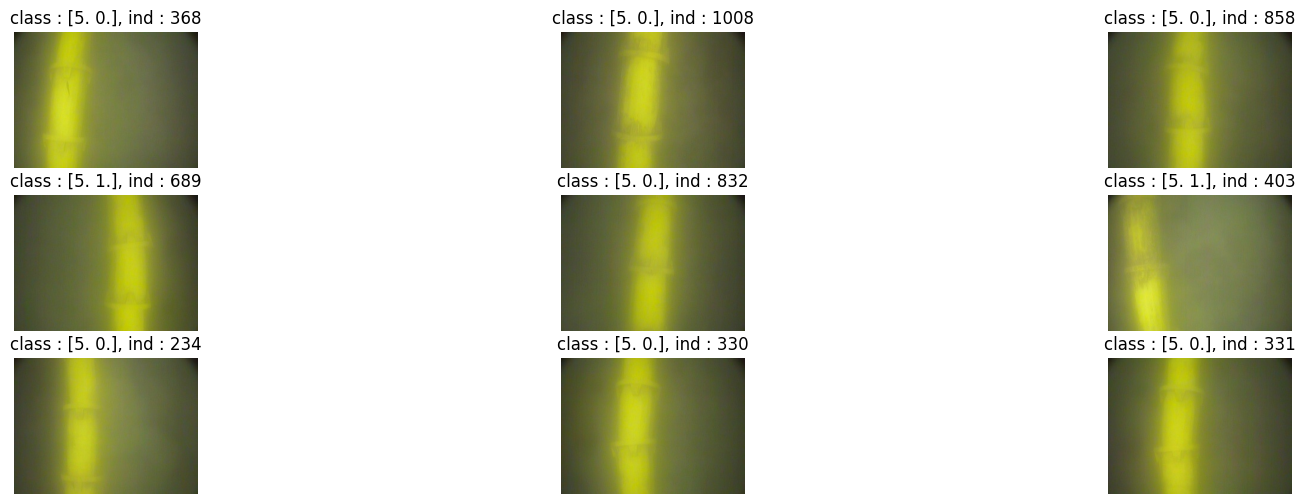

In [8]:
visualize_data_sample(x=x_data, y=y_data, random=True)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, shuffle=True)

In [10]:
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (889, 228, 308, 3)
x_test : (223, 228, 308, 3)
y_train : (889, 2)
y_test : (223, 2)


In [11]:
@keras.utils.register_keras_serializable(package="Custom")
def abs_difference_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))


In [12]:
data_augmentation = Sequential([
    RandomContrast(factor=0.01),
    RandomBrightness(factor=0.01),
    RandomZoom(height_factor=(0.1, 0.2), width_factor=(0.1,0.2)),
])

In [62]:
layers = [16, 32, 64]
strides = [1, 2, 1]
denses = [64]

In [69]:
input = Input((228, 308, 3))
#x = input
x = data_augmentation(input)


for layer, stride in zip(layers, strides):
    
    x = Conv2D(filters=layer, kernel_size=3, strides=stride)(x)
    x = ReLU()(x)
    x = MaxPool2D()(x)


x = Flatten()(x)

for dnse in denses:
    
    x = Dense(dnse)(x)
    x = Dropout(rate=0.25)(x)
    x = ReLU()(x)



classification = Dense(1, activation='sigmoid', name='classification')(x)

regression = Dense(1, name='regression')(x)


model = Model(inputs=input, outputs=[classification, regression])

In [70]:
model.summary()
opt = Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss={'classification': 'binary_crossentropy', 'regression': 'mean_squared_error'},
    metrics={'classification': 'accuracy', 'regression': 'mean_absolute_error'},
)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 228, 308,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 228, 308,  │          0 │ input_layer_15[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 226, 306,  │        448 │ sequential[14][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 226, 306,  │          0 │ conv2d_53[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 113, 153,  │          0 │ re_lu_74[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 76,    │      4,640 │ max_pooling2d_53… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_75 (ReLU)     │ (None, 56, 76,    │          0 │ conv2d_54[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 28, 38,    │          0 │ re_lu_75[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 26, 36,    │     18,496 │ max_pooling2d_54… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_76 (ReLU)     │ (None, 26, 36,    │          0 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 13, 18,    │          0 │ re_lu_76[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 14976)     │          0 │ max_pooling2d_55… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │    958,528 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_77 (ReLU)     │ (None, 64)        │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         65 │ re_lu_77[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         65 │ re_lu_77[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 982,242 (3.75 MB)

 Trainable params: 982,242 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model.fit(
    x=x_train,
    y=[y_train[:, 1].reshape((-1,1)), y_train[:, 0].reshape((-1,1))],
    batch_size=16, 
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - classification_accuracy: 0.5129 - classification_loss: 9.4480 - loss: 9849.4355 - regression_loss: 9839.2080 - regression_mean_absolute_error: 38.3579
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - classification_accuracy: 0.4365 - classification_loss: 2.6333 - loss: 10.6797 - regression_loss: 8.0461 - regression_mean_absolute_error: 2.1850
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - classification_accuracy: 0.4772 - classification_loss: 2.3629 - loss: 8.4919 - regression_loss: 6.1292 - regression_mean_absolute_error: 1.7804
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - classification_accuracy: 0.4344 - classification_loss: 2.2170 - loss: 8.9493 - regression_loss: 6.7323 - regression_mean_absolute_error: 1.7717
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - classification_accuracy: 0.4754 - classification_loss: 1.8495 - loss: 7.6334 - regression_loss: 5.7841 - regression_mean_absolute_error: 1.6313
Epoch 6

In [66]:
model.evaluate(
    x=x_test,
    y=[y_test[:, 1].reshape((-1,1)), y_test[:, 0].reshape((-1,1))]
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - classification_accuracy: 0.8701 - classification_loss: 0.3542 - loss: 0.8780 - regression_loss: 0.5236 - regression_mean_absolute_error: 0.4956


[0.9496538639068604,
 0.4062904715538025,
 0.5426252484321594,
 0.8385650515556335,
 0.5039507150650024]

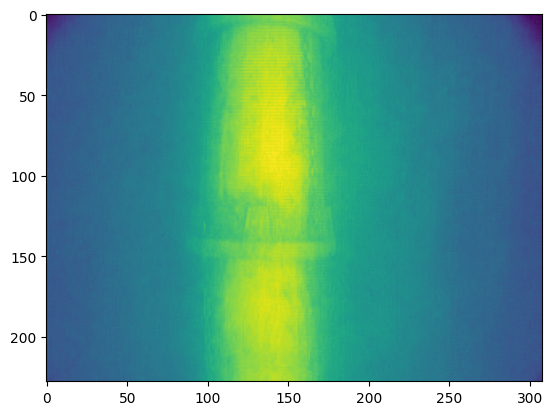

In [37]:
for img in x_test[:, 9]:
    plt.imshow(x_test[10])

In [31]:
history = history.history

(<Axes: title={'center': 'classification loss'}>,
 Text(0.5, 1.0, 'classification loss'))

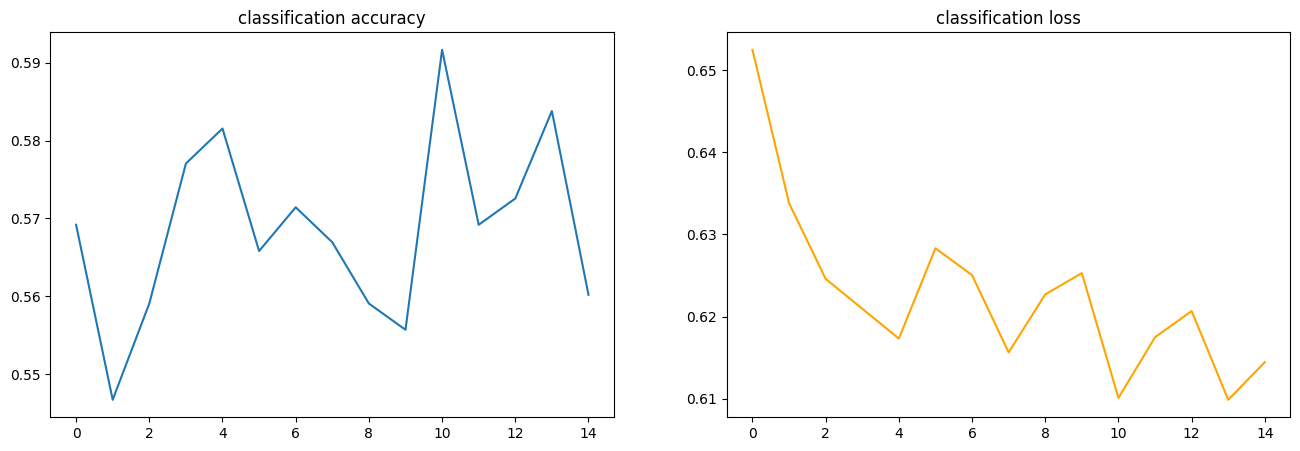

In [32]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1), plt.plot(history['classification_accuracy']), plt.title('classification accuracy')
plt.subplot(1,2,2), plt.plot(history['classification_loss'],color='orange'), plt.title('classification loss')

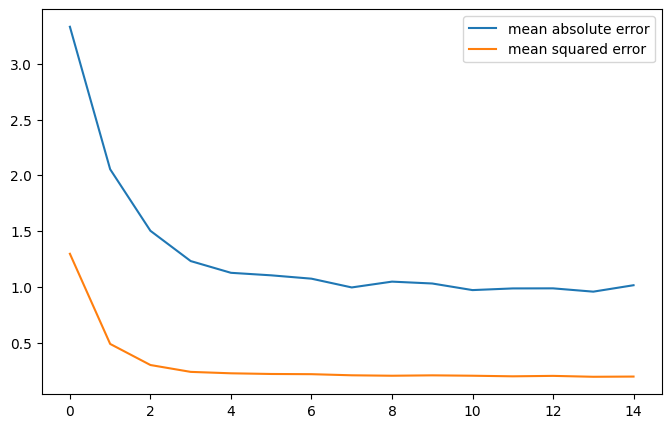

In [33]:
plt.figure(figsize=(8,5))
plt.plot(history['regression_mean_absolute_error'], label='mean absolute error')
plt.plot(history['regression_loss'], label='mean squared error')
plt.legend()


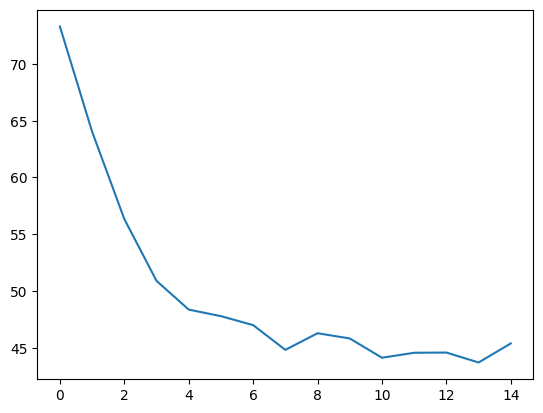

In [34]:
plt.plot(np.degrees(np.arctan(history['regression_mean_absolute_error'])), label='mean absolute error in degree')